In [1]:
from upsetplot import UpSet, from_memberships, from_contents
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import pysam
import numpy as np
from collections import Counter, defaultdict
import pyranges as pr

# Seperate GTFs into categories

In [30]:
# read in gtf file using pyranges
## Full length
gtf_fl = pr.read_gtf("../../results/full_txome_fl/txome_rmsk.gtf").df
L1_fl = gtf_fl[gtf_fl["family_id"] == "L1"]
L1_fl["Chromosome"] = L1_fl["Chromosome"].str.replace("chr", "")

# TRUNCATED
gtf_nofl = pr.read_gtf("../../results/full_txome_nofl/txome_rmsk.gtf").df
L1_nofl = gtf_nofl[gtf_nofl["family_id"] == "L1"]
L1_nofl["Chromosome"] = L1_nofl["Chromosome"].str.replace("chr", "")

/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_11072/2860233162.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L1_fl['Chromosome'] = L1_fl['Chromosome'].str.replace('chr', '')
/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_11072/2860233162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L1_nofl['Chromosome'] = L1_nofl['Chromosome'].str.replace('chr', '')


In [33]:
families = ["L1PA7", "L1PA2", "L1PA4", "L1PA3", "L1PA5", "L1PA6", "L1HS"]

for family in families:
    # combine L1_nofl and L1_fl
    L1 = pd.concat([L1_fl, L1_nofl])
    L1 = L1[L1["gene_id"] == family]
    pr.PyRanges(L1).to_gtf(f"../data/gtf_categories/{family}.gtf")

    for length in ["full", "truncate"]:
        if length == "full":
            # get the full length L1s
            new_gtf = L1_fl[L1_fl["gene_id"] == family]
        else:
            # get the truncated L1s
            new_gtf = L1_nofl[L1_nofl["gene_id"] == family]

        # split into intronic and intergenic
        intronic = new_gtf[new_gtf["contained_in"].notna()]
        intergenic = new_gtf[~new_gtf["contained_in"].notna()]
        # save to gtf file
        pr.PyRanges(intronic).to_gtf(
            f"../data/gtf_categories/{length}_intronic_{family}.gtf"
        )
        pr.PyRanges(intergenic).to_gtf(
            f"../data/gtf_categories/{length}_intergenic_{family}.gtf"
        )

# Run bedtools for gtfs
Use this or `02_bedtools_gtf.py` to make bed files from gtf files

In [34]:
import subprocess


def run_bedtools_intersect(file_path: str, family: str, best_alignment: bool):

    categories = [
        f"{family}",
        f"full_intergenic_{family}",
        f"full_intronic_{family}",
        f"truncate_intergenic_{family}",
        f"truncate_intronic_{family}",
    ]

    prefix = "/".join(file_path.split("/")[:-1])
    for cat in categories:

        cmd = [
            "bedtools",
            "intersect",
            "-abam",
            file_path,
            "-b",
            "../data/gtf_categories/" + cat + ".gtf",
            "-bed",
            "-wa",
            "-wb",
            "-f",
            "0.5",
        ]

        if best_alignment:
            # add "_best.bed"
            output_file = f"{prefix}/{cat}_best.bed"
        else:
            output_file = f"{prefix}/{cat}.bed"

        with open(output_file, "w") as outfile:
            subprocess.run(cmd, stdout=outfile)
    return output_file

In [35]:
# Get the L1 families
L1_families = ["L1HS", "L1PA2", "L1PA3", "L1PA6"]

"""if BEST_ALIGNMENT:
    bam_files = [
        "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_bestAS.bam",
        "../longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2_bestAS.bam",
        "../longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_bestAS.bam",
    ]

else:
    bam_files = [
        "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam",
        "../longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam",
        "../longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2.bam",
    ]"""


bam = "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam"
print(f"*****Processing {bam}*****")
for i, family in enumerate(L1_families):
    print(f"{i}: processing {family}")
    last_file = run_bedtools_intersect(bam, family, False)

"""bam="../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_bestAS.bam",
print(f"*****Processing {bam}*****")
for i, family in enumerate(L1_families):
    print(f"{i}: processing {family}")
    last_file = run_bedtools_intersect(bam, family, True) """

*****Processing ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam*****
0: processing L1HS


***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDN

1: processing L1PA2


***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDN

2: processing L1PA3


***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDN

3: processing L1PA6


***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDN

*****Processing ('../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_bestAS.bam',)*****
0: processing L1HS


***** WARNING: File ../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-



AttributeError: 'tuple' object has no attribute 'split'

# Make upset plots

In [5]:
"""
reads bedfiles for categories in path and return dataframe compatible with upsetplot
@param base_path: str path to bedfiles
@param categories: str list of categories to read
@return: dataframe compatible with upsetplot
"""


def read_data(
    base_path, categories, seperate_unique_multi=False, reads_path=None
) -> pd.DataFrame():

    if seperate_unique_multi:
        with open(reads_path, "r") as f:
            unique_reads = f.read().split()

    ids = {}
    # get list of read_ids for each sample
    for cat in categories:

        # if bed file is empty
        if Path(f"{base_path}/{cat}.bed").stat().st_size == 0:
            continue

        if not seperate_unique_multi:
            ids[cat] = (
                pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]
                .drop_duplicates()
                .to_list()
            )
        else:
            # iterate through reads and determine if unique or not
            ids[cat + "_unique"] = []
            ids[cat + "_multi"] = []
            for read in (
                pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]
                .drop_duplicates()
                .to_list()
            ):
                if read in unique_reads:
                    ids[cat + "_unique"].append(read)
                else:
                    ids[cat + "_multi"].append(read)

    return from_contents(ids)

In [14]:
df = pd.read_csv(
    "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/full_intergenic_L1HS.bed",
    sep="\t",
    header=None,
)

readspath = "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_unique_reads.txt"
with open(readspath, "r") as f:
    unique_reads = f.read().split()

# get unique reads in df[3]
df[df[3].isin(unique_reads)]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
1,1,196219379,196221472,42e0036c-9743-48c8-ad43-65592461161f,9,+,196219379,196221472,"0,0,0",1,...,"0,",1,RepeatMasker,exon,196219371,196225402,.,-,.,"transcript_id ""L1HS_dup8""; gene_id ""L1HS""; gen..."
48,18,13978146,13979949,c4409fbd-c828-472a-81bf-15c2df7fd85b,31,+,13978146,13979949,"0,0,0",1,...,"0,",18,RepeatMasker,exon,13975861,13981891,.,-,.,"transcript_id ""L1HS_dup49""; gene_id ""L1HS""; ge..."
122,7,97613655,97614986,82636af0-cb81-431a-aa79-91d7f2fac12b,16,-,97613655,97614986,"0,0,0",1,...,"0,",7,RepeatMasker,exon,97613657,97619688,.,+,.,"transcript_id ""L1HS_dup130""; gene_id ""L1HS""; g..."


In [15]:
df = pd.read_csv(
    "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/truncate_intergenic_L1HS.bed",
    sep="\t",
    header=None,
)

readspath = "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_unique_reads.txt"
with open(readspath, "r") as f:
    unique_reads = f.read().split()

# get unique reads in df[3]
df[df[3].isin(unique_reads)]

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
3,1,73193312,73195351,7f8163a6-ac7c-436d-add8-70e59b77afc5,60,+,73193312,73195351,"0,0,0",1,...,"0,",1,RepeatMasker,exon,73193584,73195007,.,+,.,"transcript_id ""L1HS_dup23""; gene_id ""L1HS""; ge..."
21,1,196219379,196221472,42e0036c-9743-48c8-ad43-65592461161f,9,+,196219379,196221472,"0,0,0",1,...,"0,",1,RepeatMasker,exon,196219371,196225402,.,-,.,"transcript_id ""L1HS_dup102""; gene_id ""L1HS""; g..."
36,10,81769122,81770206,3809cbe6-1a45-46cd-bbbc-c87b468d431f,22,+,81769122,81770206,"0,0,0",1,...,"0,",10,RepeatMasker,exon,81768382,81773241,.,-,.,"transcript_id ""L1HS_dup163""; gene_id ""L1HS""; g..."
50,11,24333463,24334169,d3d0644d-5d91-4dd0-b64a-cbeeb546fec3,46,+,24333463,24334169,"0,0,0",1,...,"0,",11,RepeatMasker,exon,24327952,24334001,.,+,.,"transcript_id ""L1HS_dup194""; gene_id ""L1HS""; g..."
67,12,61002557,61002874,4b6dc6c9-af77-4f47-b38d-f92cf85a9076,3,+,61002557,61002874,"0,0,0",1,...,"0,",12,RepeatMasker,exon,61002560,61003286,.,-,.,"transcript_id ""L1HS_dup277""; gene_id ""L1HS""; g..."
106,14,84956011,84956221,147e5f0f-8395-4a94-8929-b97ec4e67888,16,-,84956011,84956221,"0,0,0",1,...,"0,",14,RepeatMasker,exon,84956078,84956198,.,+,.,"transcript_id ""L1HS_dup390""; gene_id ""L1HS""; g..."
113,16,35532530,35538642,fec5fb5c-427f-403f-9d9b-7e92a8b08512,60,+,35532530,35538642,"0,0,0",1,...,"0,",16,RepeatMasker,exon,35534415,35537679,.,-,.,"transcript_id ""L1HS_dup440""; gene_id ""L1HS""; g..."
123,18,13978146,13979949,c4409fbd-c828-472a-81bf-15c2df7fd85b,31,+,13978146,13979949,"0,0,0",1,...,"0,",18,RepeatMasker,exon,13975861,13981891,.,-,.,"transcript_id ""L1HS_dup488""; gene_id ""L1HS""; g..."
182,2,223039314,223039912,69096fb8-e074-4c07-8238-1be25085a58b,60,+,223039314,223039912,"0,0,0",1,...,"0,",2,RepeatMasker,exon,223039347,223039690,.,+,.,"transcript_id ""L1HS_dup656""; gene_id ""L1HS""; g..."
210,3,36622565,36622692,cc589f33-d8cc-4e29-88b3-19e5f6ded796,8,-,36622565,36622692,"0,0,0",1,...,"0,",3,RepeatMasker,exon,36621476,36625027,.,-,.,"transcript_id ""L1HS_dup739""; gene_id ""L1HS""; g..."


In [8]:
path = "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3"

readspath = "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_unique_reads.txt"
bestreadspath = "../longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_unique_reads_best.txt"

L1_families = ["L1HS", "L1PA2"]
regions = [
    "full_intergenic",
    "full_intronic",
    "truncate_intergenic",
    "truncate_intronic",
]


def make_a_plot(path, categories, seperate_unique_multi=False, reads_path=None):
    data = read_data(path, categories, seperate_unique_multi, reads_path)
    UpSet(data, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
    plt.suptitle(path)
    plt.show()
    plt.clf()

/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21360/1490814937.py:27: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]
/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21360/1490814937.py:27: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]


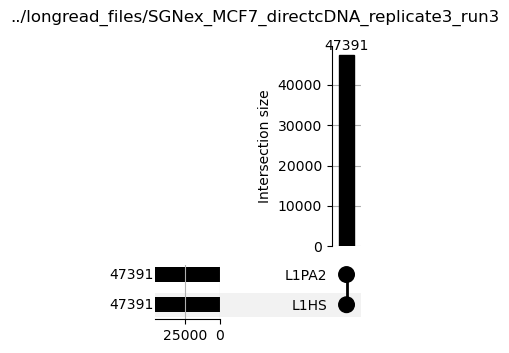

/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21360/1490814937.py:27: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]
/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21360/1490814937.py:27: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]


<Figure size 640x480 with 0 Axes>

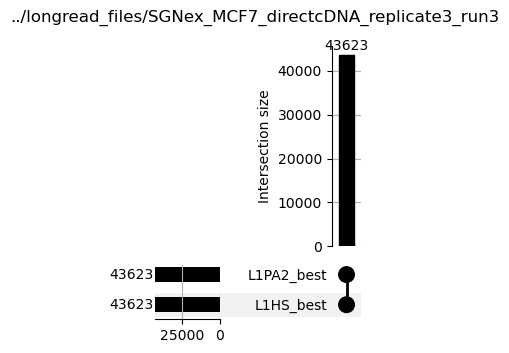

/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21360/1490814937.py:36: DtypeWarning: Columns (0,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{base_path}/{cat}.bed", sep="\t", header=None)[3]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [9]:
make_a_plot(path, categories=L1_families)
make_a_plot(path, categories=[bed + "_best" for bed in L1_families])
make_a_plot(
    path, categories=L1_families, seperate_unique_multi=True, reads_path=readspath
)
"""make_a_plot(
    path,
    categories=[bed + "_best" for bed in L1_families],
    seperate_unique_multi=True,
    reads_path=bestreadspath,
)"""

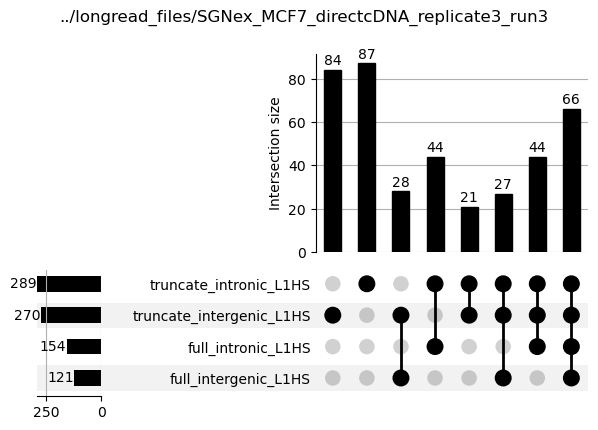

<Figure size 640x480 with 0 Axes>

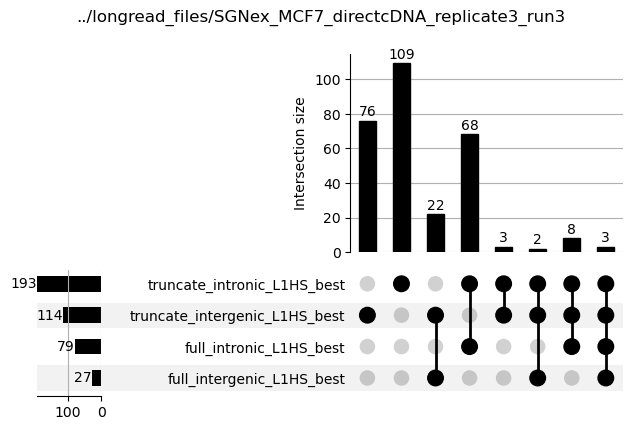

<Figure size 640x480 with 0 Axes>

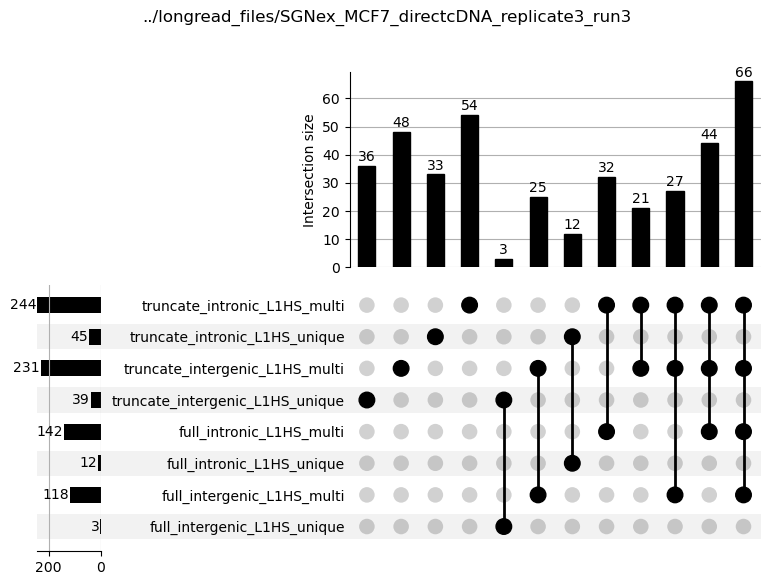

<Figure size 640x480 with 0 Axes>

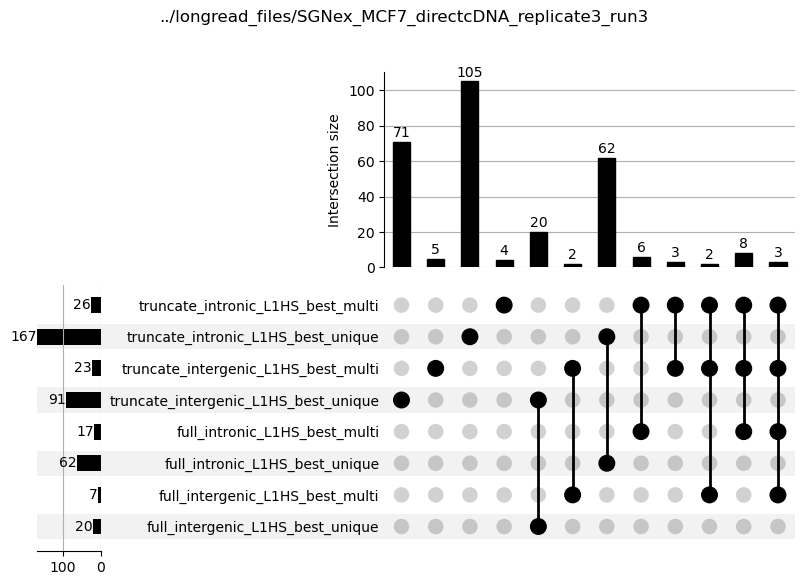

<Figure size 640x480 with 0 Axes>

In [10]:
make_a_plot(path, categories=[cat + "_L1HS" for cat in regions])
make_a_plot(path, categories=[cat + "_L1HS_best" for cat in regions])
make_a_plot(
    path,
    categories=[cat + "_L1HS" for cat in regions],
    seperate_unique_multi=True,
    reads_path=readspath,
)
make_a_plot(
    path,
    categories=[cat + "_L1HS_best" for cat in regions],
    seperate_unique_multi=True,
    reads_path=bestreadspath,
)